In [7]:
import tensorflow as tf

# 定义一个简单的计算图，实现向量加法的操作
input1 = tf.constant([1.0, 2.0, 3.0], name='input1')
input2 = tf.Variable(tf.random_uniform([3]), name='input2')
output = tf.add_n([input1, input2], name='add')

# 生成一个写日志的writer，并将当前的Tensorflow计算图写入日志
writer = tf.summary.FileWriter('/opt/jupyter_files/log', tf.get_default_graph())
writer.close()

使用命令：**tensorboard --logdir=/opt/jupyter_files/log**，然后根据提示打开可视化页面
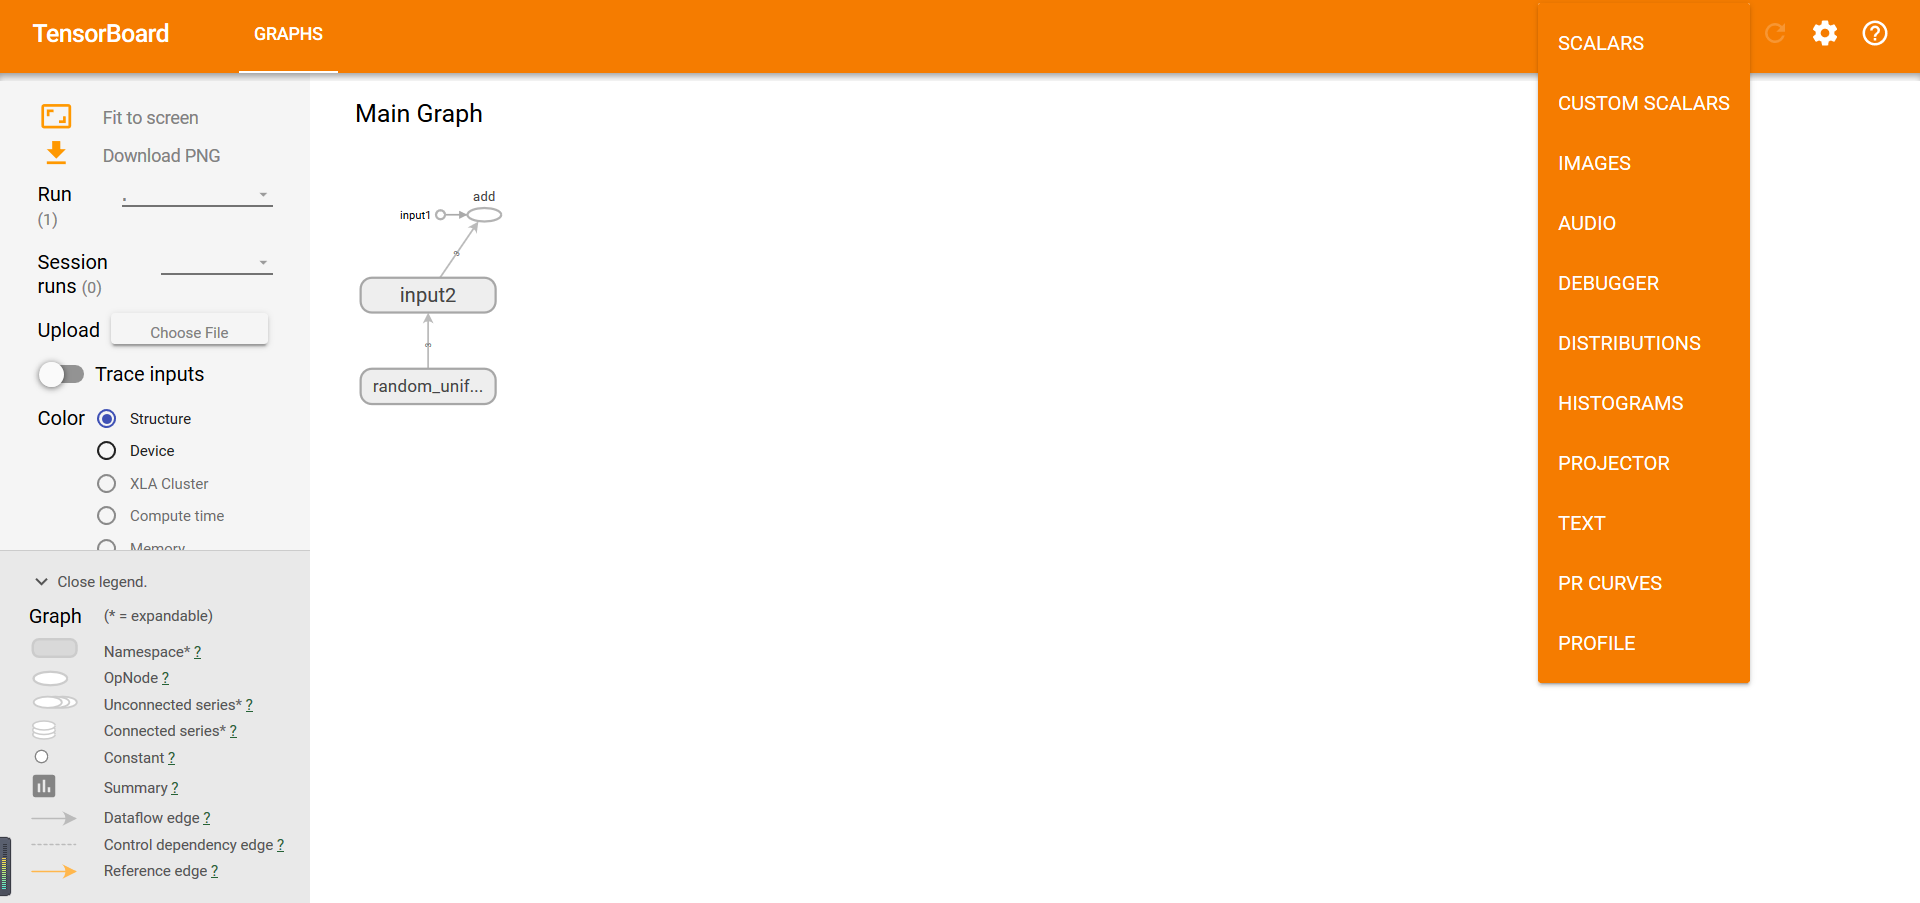

# 命名空间

In [2]:
import tensorflow as tf

with tf.variable_scope('foo'):
    # 在命名空间foo下获取变量'bar'，于是得到的变量名称为'foo/bar'
    a = tf.get_variable('bar', [1])
    print(a.name)
    
with tf.variable_scope('bar'):
    # 在命名空间bar下获取变量'bar'，其名称为'bar/bar'
    b = tf.get_variable('bar', [1])
    print(b.name)
    
with tf.name_scope('a'):
    # 使用tf.Variable函数生成的变量会受tf.name_scope影响，其名称为'a/Variable'
    a = tf.Variable([1])
    print(a.name)
    
    # tf.get_variable函数不受tf.name_scope函数的影响 
    a = tf.get_variable('b', [1])
    print(a.name)
    
# with tf.name_scope('b'):
#     # 因为tf.get_variable不受tf.name_scope影响
#     # 所以这里会将获取名称'a'的变量
#     # 然而这个变量已经被声明了，因此会报重复声明的错误
#     tf.get_variable('b', [1])

foo/bar:0
bar/bar:0
a/Variable:0
b:0


In [4]:
# 改进两向量相加的样例代码
import tensorflow as tf

tf.reset_default_graph()

# 将输入定义放入各自的命名空间中，从而使得Tensorboard可根据命名空间来整理可视化节点
with tf.name_scope('input1'):
    input1 = tf.constant([1.0, 2.0, 3.0], name='input1')
    
with tf.name_scope('input2'):
    input2 = tf.Variable(tf.random_uniform([3]), name='input2')

output = tf.add_n([input1, input2], name='add')

writer = tf.summary.FileWriter('/opt/jupyter_files/log', tf.get_default_graph())
writer.close()

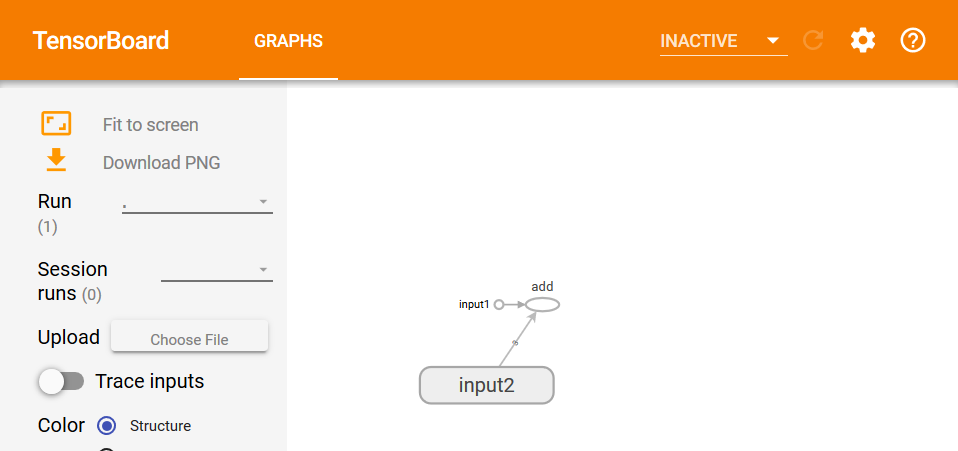

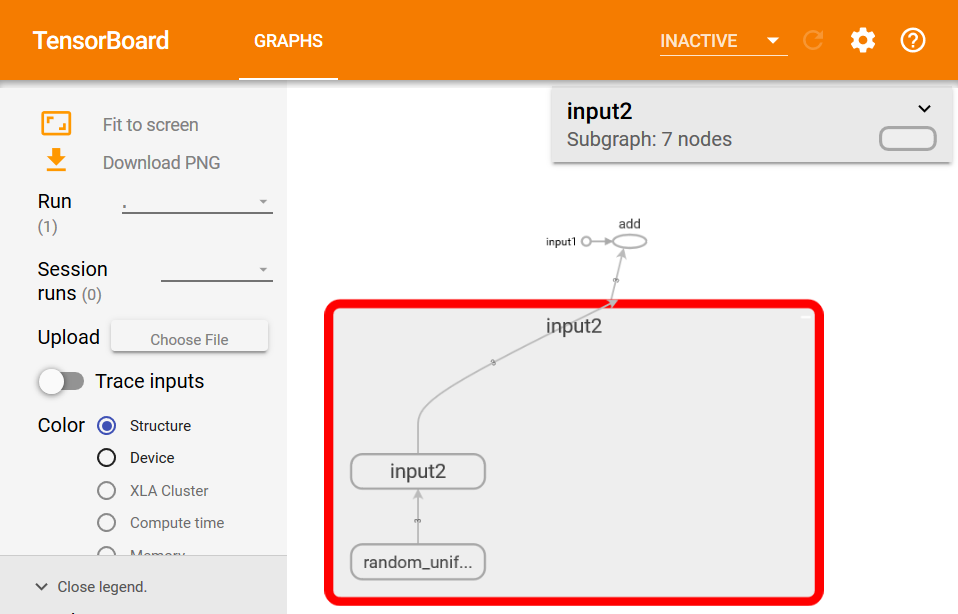

In [5]:
# 定义了前向传播的过程以及神经网络的参数。实际可单独放入一个文件，如mnist_inference.py
# -*- coding: utf-8 -*-
import tensorflow as tf

# 定义神经网络结构相关的参数
INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500

# 通过tf.get_variable函数来获取变量，在训练神经网络时会创建这些变量
# 在测试时会通过保存的模型加载这些变量的取值
# 因为可以在变量加载时将滑动平均变量重命名
# 所以可以直接通过相同的名字在训练时使用变量自身，而在测试时使用变量的滑动平均值
# 在这个函数中也会将变量的正则化损失加入损失集合
def get_weight_variable(shape, regularizer):
    weights = tf.get_variable('weights',
                              shape,
                             initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    # 当给出了正则化生成函数时，将当前变量的正则化损失加入名字为losses的集合
    # 在这里使用了add_to_collection函数将一个张量加入一个集合
    # 而这个集合的名称为losses，这是自定义集合，不在Tensorflow自动管理的集合列表中
    if regularizer != None:
        tf.add_to_collection('losses', regularizer(weights))
        
    return weights

# 定义神经网络的前向传播过程
def inference(input_tensor, regularizer):
    # 声明第一层神经网络的变量并完成前向传播过程
    with tf.variable_scope('layer1'):
        # 这里通过tf.get_variable或tf.Variable没有本质区别
        # 因为在训练或是测试中没有在同一个程序中多次调用这个函数
        # 如果在同一个程序中多次调用，在第一次调用之后需要将reuse参数设置为True
        weights = get_weight_variable([INPUT_NODE, LAYER1_NODE], regularizer)
        biases = tf.get_variable('biases',
                                 [LAYER1_NODE],
                                initializer=tf.constant_initializer(0.0))
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + biases)
    
    # 类似的声明第二层神经网络的变量并完成前向传播过程
    with tf.variable_scope('layer2'):
        weights = get_weight_variable([LAYER1_NODE, OUTPUT_NODE], regularizer)
        biases = tf.get_variable('biases',
                                 [OUTPUT_NODE],
                                initializer=tf.constant_initializer(0.0))
        layer2 = tf.matmul(layer1, weights) + biases
    
    # 返回最后前向传播的结果
    return layer2

In [18]:
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data
# mnist_inference中定义的常量和前向传播的函数不需要改变
# 因为前向传播已经通过tf.variable_scope实现了计算节点按照网络结构的划分

INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500

# 配置神经网络的参数
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 30000
MOVING_AVERAGE_DECAY = 0.99

# 模型保存的路径和文件名
MODEL_SAVE_PATH = '/opt/jupyter_files/model-saves/mnist_model/'
MODEL_NAME = 'mnist.ckpt'

def train(mnist):
    tf.reset_default_graph()
    
    # 将处理输入数据的计算都放在名字为'input'的命名空间下
    with tf.name_scope('input'):
        x = tf.placeholder(
            tf.float32,
            [None, INPUT_NODE],
            name='x-input')
        y_ = tf.placeholder(
            tf.float32,
            [None, OUTPUT_NODE],
            name='y-input')
    
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    y = inference(x, regularizer)
    global_step = tf.Variable(0, trainable=False)
    
    # 将处理滑动平均相关的计算都放在名为moving_average的命名空间下
    with tf.name_scope('moving_average'):
        variable_averages = tf.train.ExponentialMovingAverage(
            MOVING_AVERAGE_DECAY,
            global_step)
        variable_averages_op = variable_averages.apply(tf.trainable_variables())
        
    # 将计算损失函数相关的计算都放在名为loss_function的命名空间下
    with tf.name_scope('loss_function'):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=tf.argmax(y_, 1), 
            logits=y)
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
        
    # 将定义学习率、优化方法以及每一轮训练需要执行的操作都放在名字为'train_step'空间下
    with tf.name_scope('train_step'):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE,
            global_step,
            mnist.train.num_examples / BATCH_SIZE,
            LEARNING_RATE_DECAY,
            staircase=True)
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
        with tf.control_dependencies([train_step, variable_averages_op]):
            train_op = tf.no_op(name='train')
            
        # 初始化Tensorflow持久化类，max_to_keep参数指定保留多少最新模型信息
        saver = tf.train.Saver(max_to_keep=10)
        with tf.Session() as sess:
            tf.global_variables_initializer().run()

            # 在训练过程中不再测试模型在验证数据上的表现
            # 验证和测试的过程将会有一个独立的程序来完成
            for i in range(TRAINING_STEPS):
                xs, ys = mnist.train.next_batch(BATCH_SIZE)
                _, loss_value, step = sess.run([train_op, loss, global_step],
                                              feed_dict={x: xs, y_: ys})

                # 每1000轮保存一次模型
                if i % 1000 == 0:
                    # 输出当前的训练情况，这里只输出了模型在当前训练batch上的损失函数大小
                    # 通过损失函数的大小可以大概了解训练的情况
                    # 在验证数据集上的正确率信息会有一个单独的程序来生成
                    print('After %d training step(s), loss on training batch is %g.'
                          % (step, loss_value))
                    #  保存当前模型。注意这里给出了global_step参数
                    # 可以让每个被保存模型的文件名末尾加上训练的轮数
                    saver.save(sess,
                              os.path.join(MODEL_SAVE_PATH, MODEL_NAME),
                              global_step=global_step)
                
    writer = tf.summary.FileWriter('/opt/jupyter_files/log', tf.get_default_graph())
    writer.close()
    
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=True)
    train(mnist)
    
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
After 1 training step(s), loss on training batch is 2.76441.
After 1001 training step(s), loss on training batch is 0.220977.
After 2001 training step(s), loss on training batch is 0.168402.
After 3001 training step(s), loss on training batch is 0.27784.
After 4001 training step(s), loss on training batch is 0.151607.
After 5001 training step(s), loss on training batch is 0.107428.
After 6001 training step(s), loss on training batch is 0.110912.
After 7001 training step(s), loss on training batch is 0.094447.
After 8001 training step(s), loss on training batch is 0.0792353.
After 9001 training step(s), loss on training batch is 0.0804835.
After 10001 training step(s), loss on training batch is 0.070572.
After 11001 training step(s), loss on

SystemExit: 

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


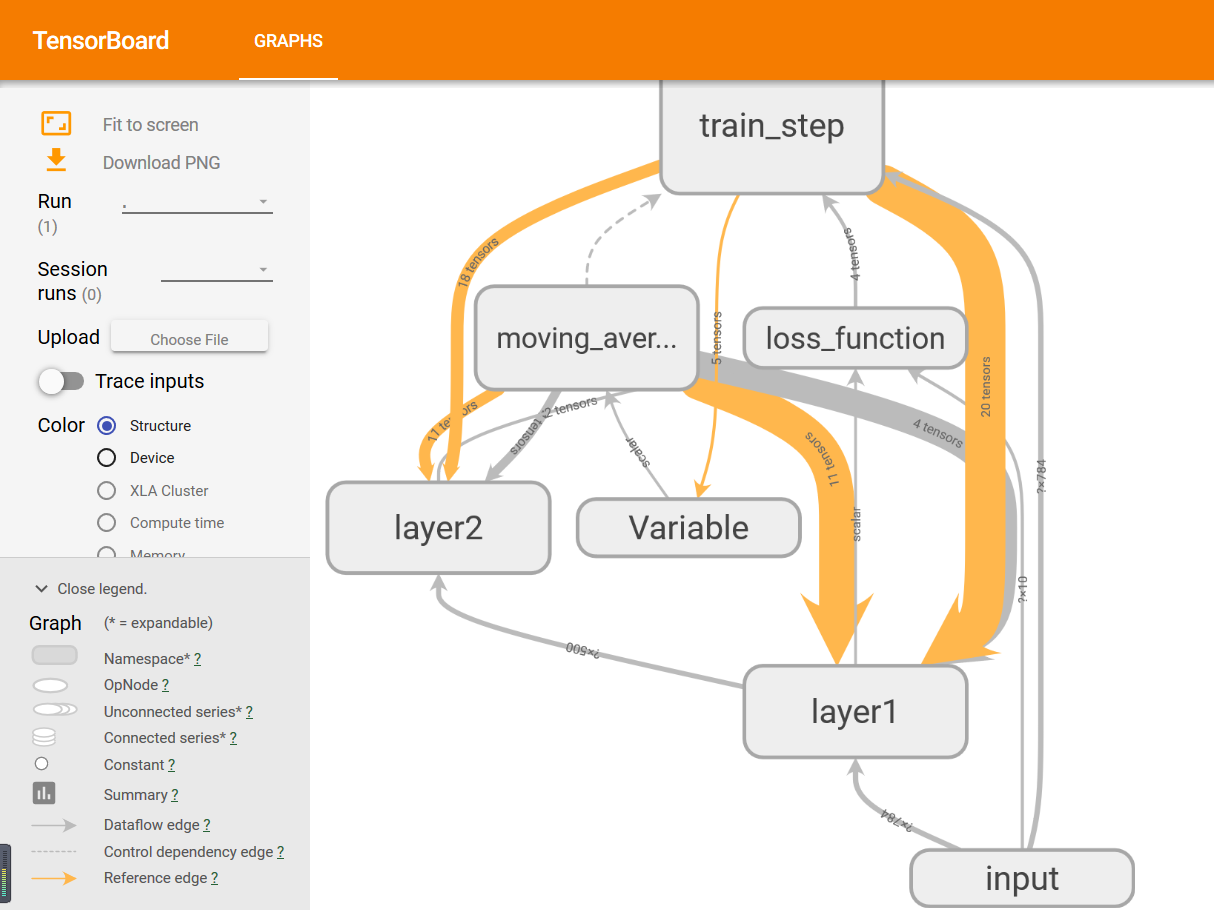

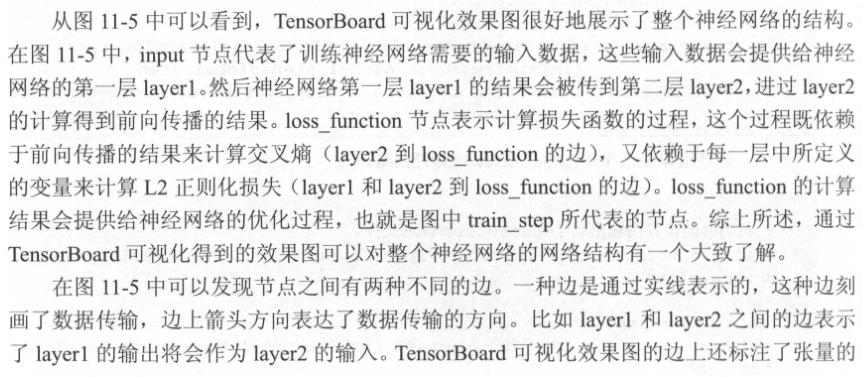

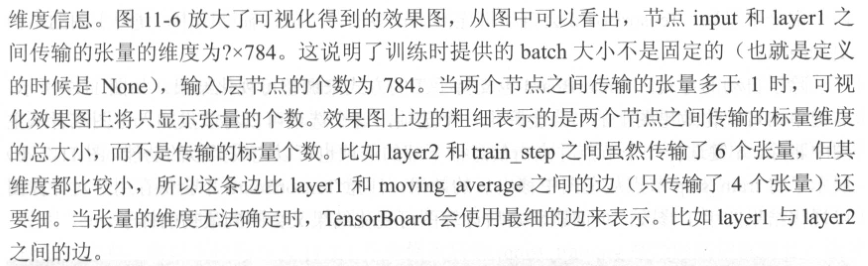

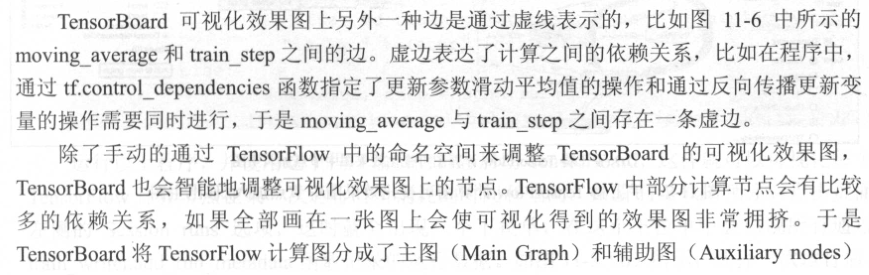

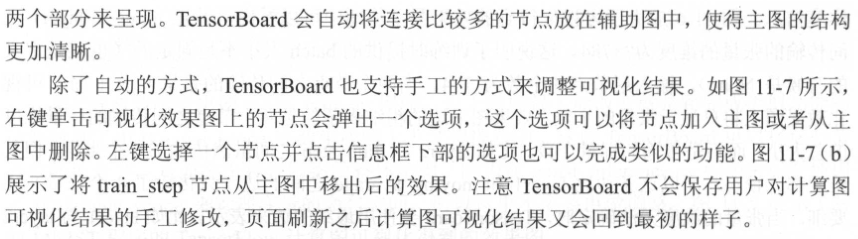

## 节点信息
将下述代码替换上述代码相关部分，可以使用Tensorboard直观地展示所有计算节点在某一次运行时所消耗的时间和内存

In [ ]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    train_writer = tf.summary.FileWriter("/opt/jupyter_files/log", sess.graph)
    for i in range(TRAINING_STEPS):
        xs, ys = mnist.train.next_batch(BATCH_SIZE)
        
        # 每1000轮记录一次运行状态
        if i % 1000 == 0:
            # 配置运行时需要记录的信息
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            # 运行时记录运行信息的proto
            run_metadata = tf.RunMetadata()
            # 将配置信息和记录运行信息的proto传入运行的过程
            # 从而记录运行时每一个节点的时间、空间开销信息
            _, loss_value, step = sess.run(
                [train_op, loss, global_step],
                feed_dict={x: xs, y_: ys},
                options=run_options,
                run_metadata=run_metadata)
            # 将节点在运行时的信息写入日志文件
            train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
            print('After %d training step(s), loss on training batch is %g.'
                 % (step, loss_value))
        else:
            _, loss_value, step = see.run(
                [train_op, loss, global_step],
                feed_dict={x: xs, y_: ys})

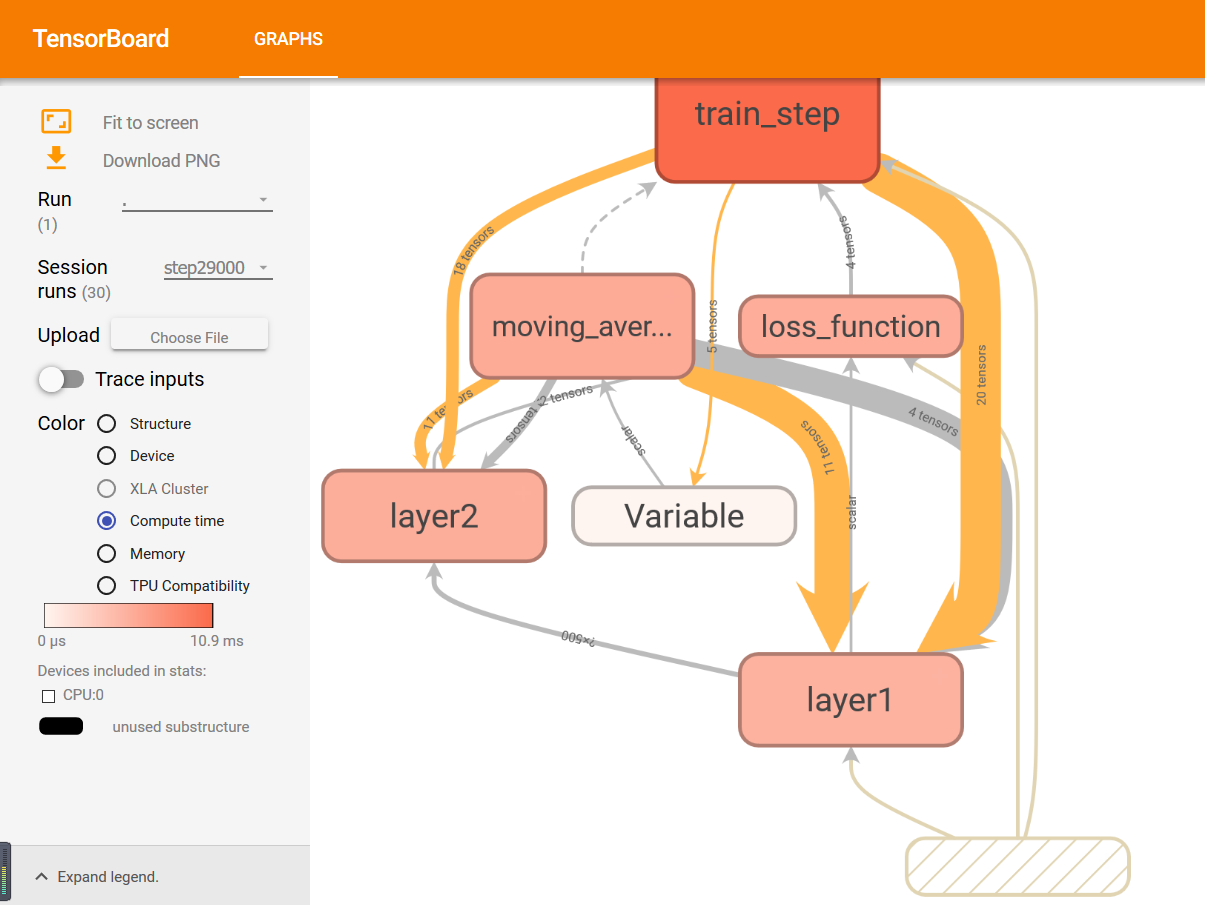

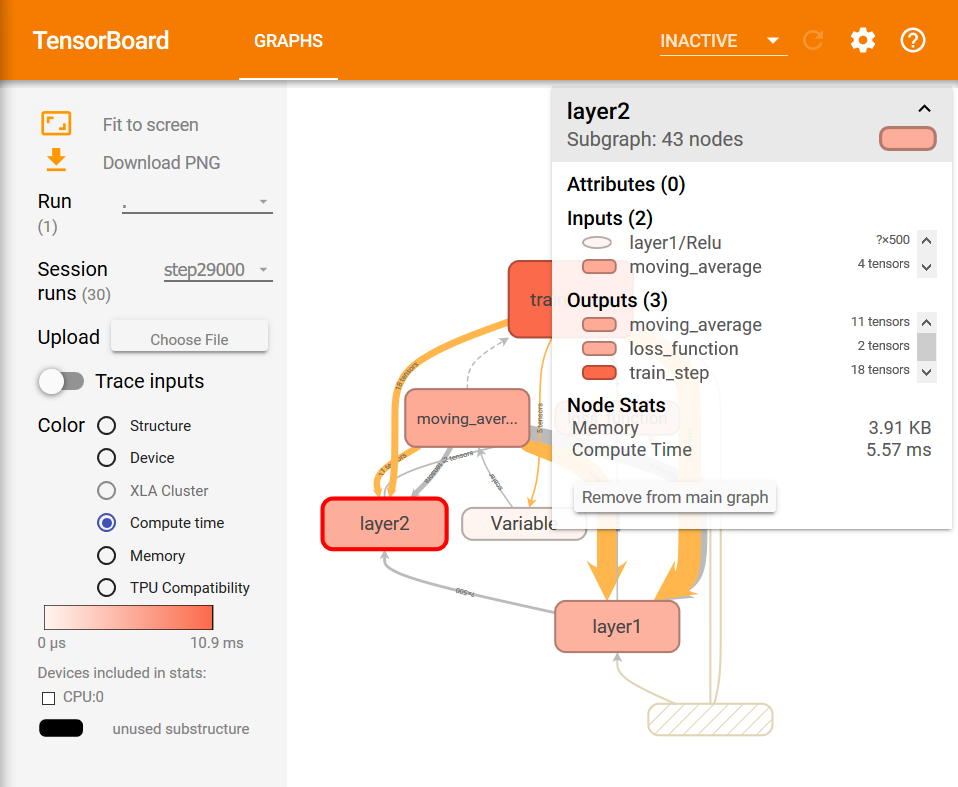

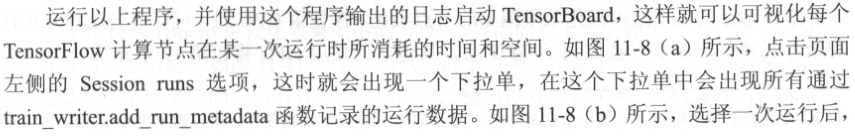

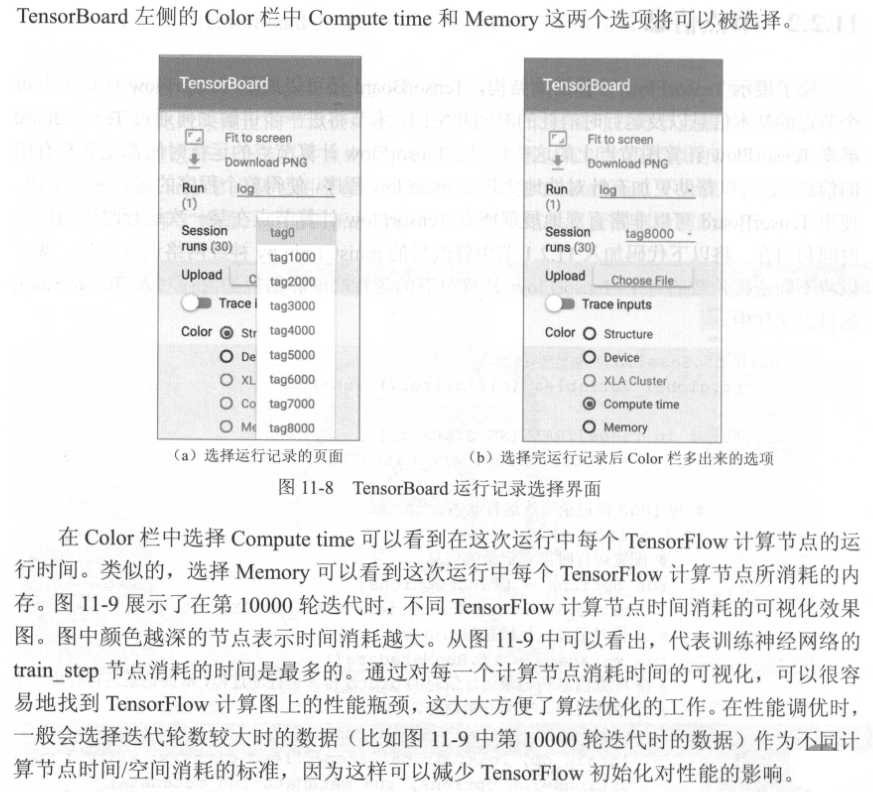

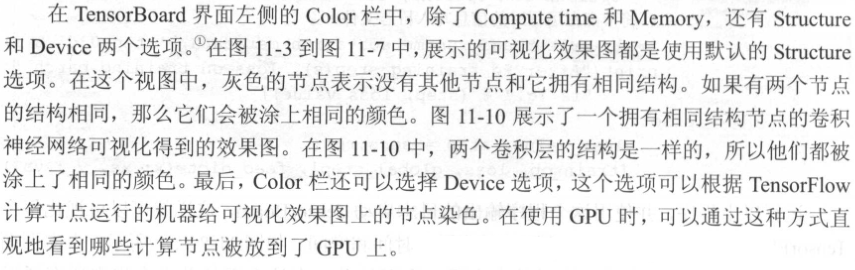

## 监控指标可视化

In [34]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

SUMMARY_DIR = '/opt/jupyter_files/log'
BATCH_SIZE = 100
TRAIN_STEPS = 3000

# 生成变量监控信息并定义生成监控信息日志的操作
# var给出了需要记录的张量，name给出了可视化结果中显示的图表名称，一般与变量名一致
def variable_summaries(var, name):
    # 将生成监控信息的操作放到同一个命名空间下
    with tf.name_scope('summaries'):
        # 通过下述函数记录张量中元素的取值分布
        # 对于给出的图表名称和张量，其会生成一个Summary protocol buffer
        # 将Summary写入TensorBoard日志文件后，会出现在HISTOGRAMS栏和DISTRIBUTION栏
        # 该函数不会立即执行，只有当sess.run调用时才会运行
        tf.summary.histogram(name, var)
        
        # 计算变量的平均值，并定义生成平均值信息日志的操作
        # 记录变量平均值信息的日志标签名为'mean/'+name，其中mean为命名空间，/为分隔符
        # 在相同命名空间中的监控指标会被整合到同一栏中，name给出当前监控指标输入哪个变量
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        # 计算变量的标准差，并定义生成其日志的操作
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev/' + name, stddev)
        
# 生成一层全连接层神经网络
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    # 将同一层神经网络放在一个统一的命名空间下
    with tf.name_scope(layer_name):
        # 声明神经网络上的权值，并调用生成权重监控信息日志的函数
        with tf.name_scope('weights'):
            weights = tf.Variable(tf.truncated_normal([input_dim, output_dim],
                                                      stddev=0.1))
            variable_summaries(weights, layer_name + '/weights')

        # 声明神经网络的偏置项，并调用生成偏置项监控信息日志的函数
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.constant(0.0, shape=[output_dim]))
            variable_summaries(biases, layer_name + '/biases')

        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            # 记录神经网络输出节点在经过激活函数之前的分布
            tf.summary.histogram(layer_name + '/pre_activations', preactivate)

        activations = act(preactivate, name='activation')

        # 记录神经网络输出节点在经过激活函数之后的分布
        tf.summary.histogram(layer_name + '/activations', activations)
        return activations

def main(argv=None):
    tf.reset_default_graph()
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST',
                                      False,
                                      one_hot=True)
    
    # 定义输入
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, 784], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, 10], name='y-input')
        
    # 将输入向量还原成图片的像素矩阵
    # 并通过tf.summary.image函数定义将当前图片信息写入日志的操作
    with tf.name_scope('input_reshape'):
        image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])
        tf.summary.image('input', image_shaped_input, 10)
        
    hidden1 = nn_layer(x, 784, 500, 'layer1')
    y = nn_layer(hidden1, 500, 10, 'layer2', act=tf.identity)
    
    # 计算交叉熵并定义生成交叉熵监控日志的操作
    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=y_,
            logits=y))
        tf.summary.scalar('cross_entropy', cross_entropy)
        
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
        
    # 计算模型在当前给定数据上的正确率，并定义生成正确率监控日志的操作
    # 如果在sess.run时给定的数据是训练batch，那么得到的就是这个训练batch上的正确率
    # 如果数据为验证或测试数据，那么得到的正确率就是当前模型在验证或测试上的正确率
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    # 下述函数可以整理所有的日志生成操作
    merged = tf.summary.merge_all()
    
    with tf.Session() as sess:
        # 初始化写日志的writer。并将当前计算图写入日志
        summary_writer = tf.summary.FileWriter(SUMMARY_DIR, sess.graph)
        tf.global_variables_initializer().run()
        
        for i in range(TRAIN_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            # 运行训练步骤以及所有的日志生成文件，得到这次运行的日志
            summary, _ = sess.run([merged, train_step],
                                 feed_dict={x: xs, y_: ys})
            # 将所有日志写入文件
            summary_writer.add_summary(summary, i)
            
    summary_writer.close()
    
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz


SystemExit: 

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


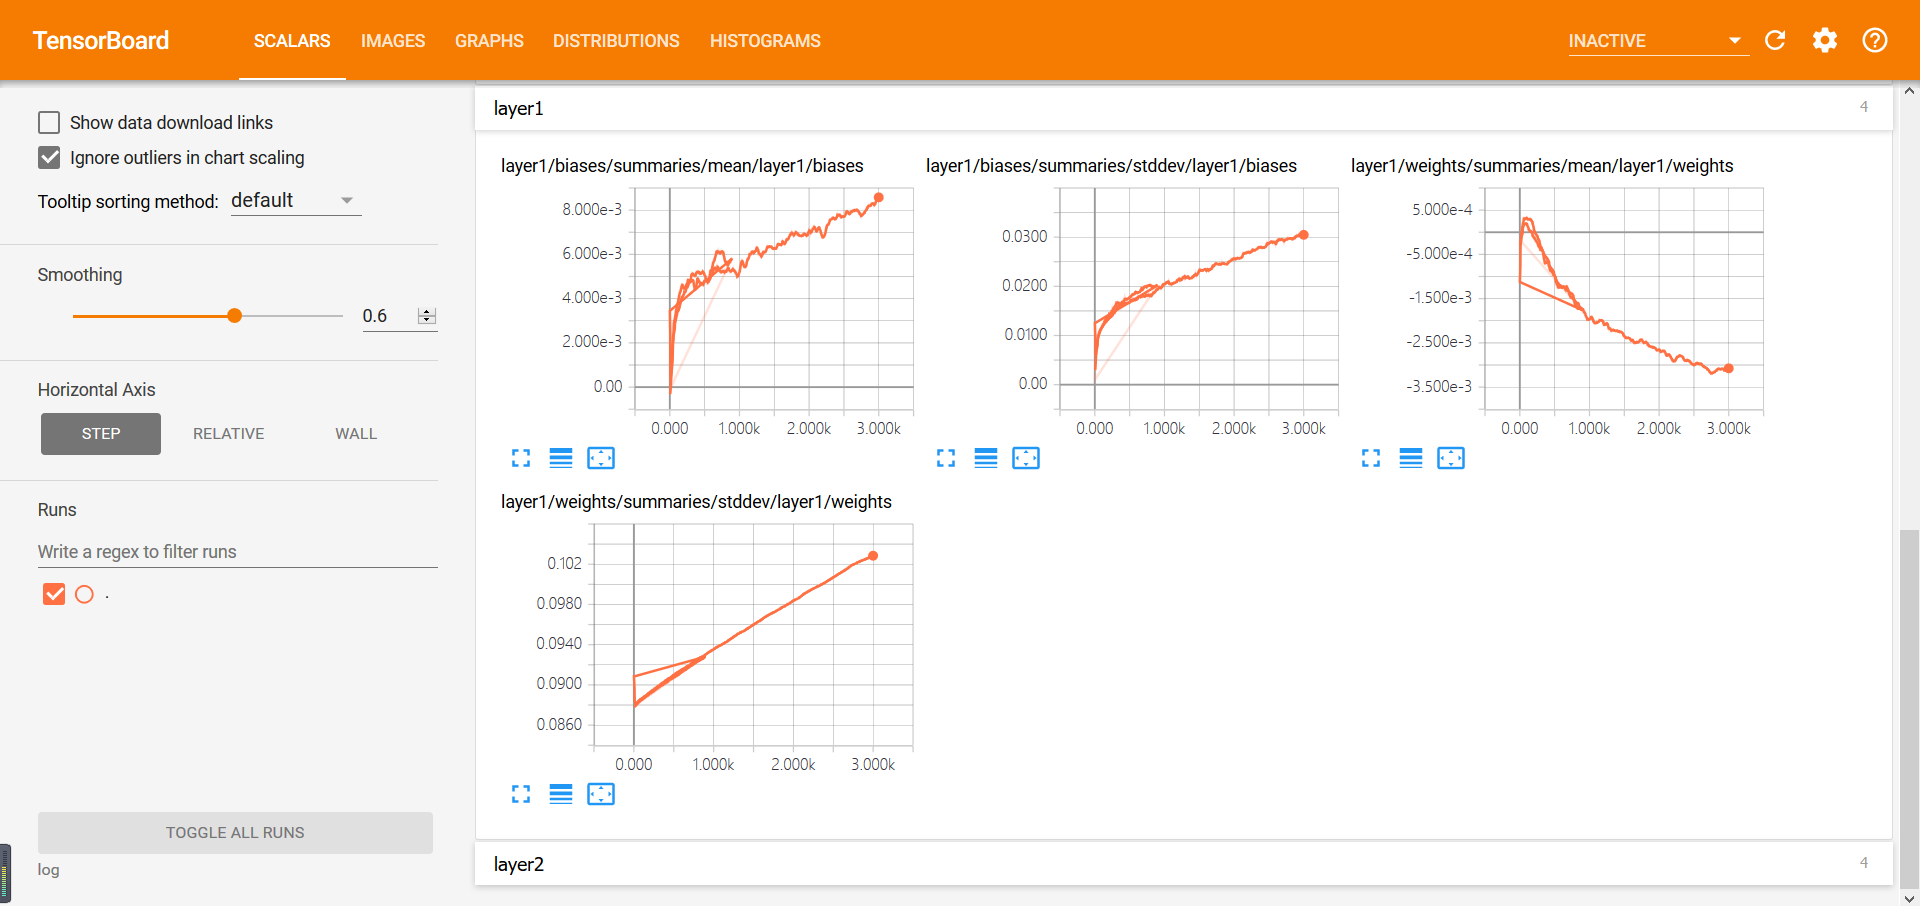

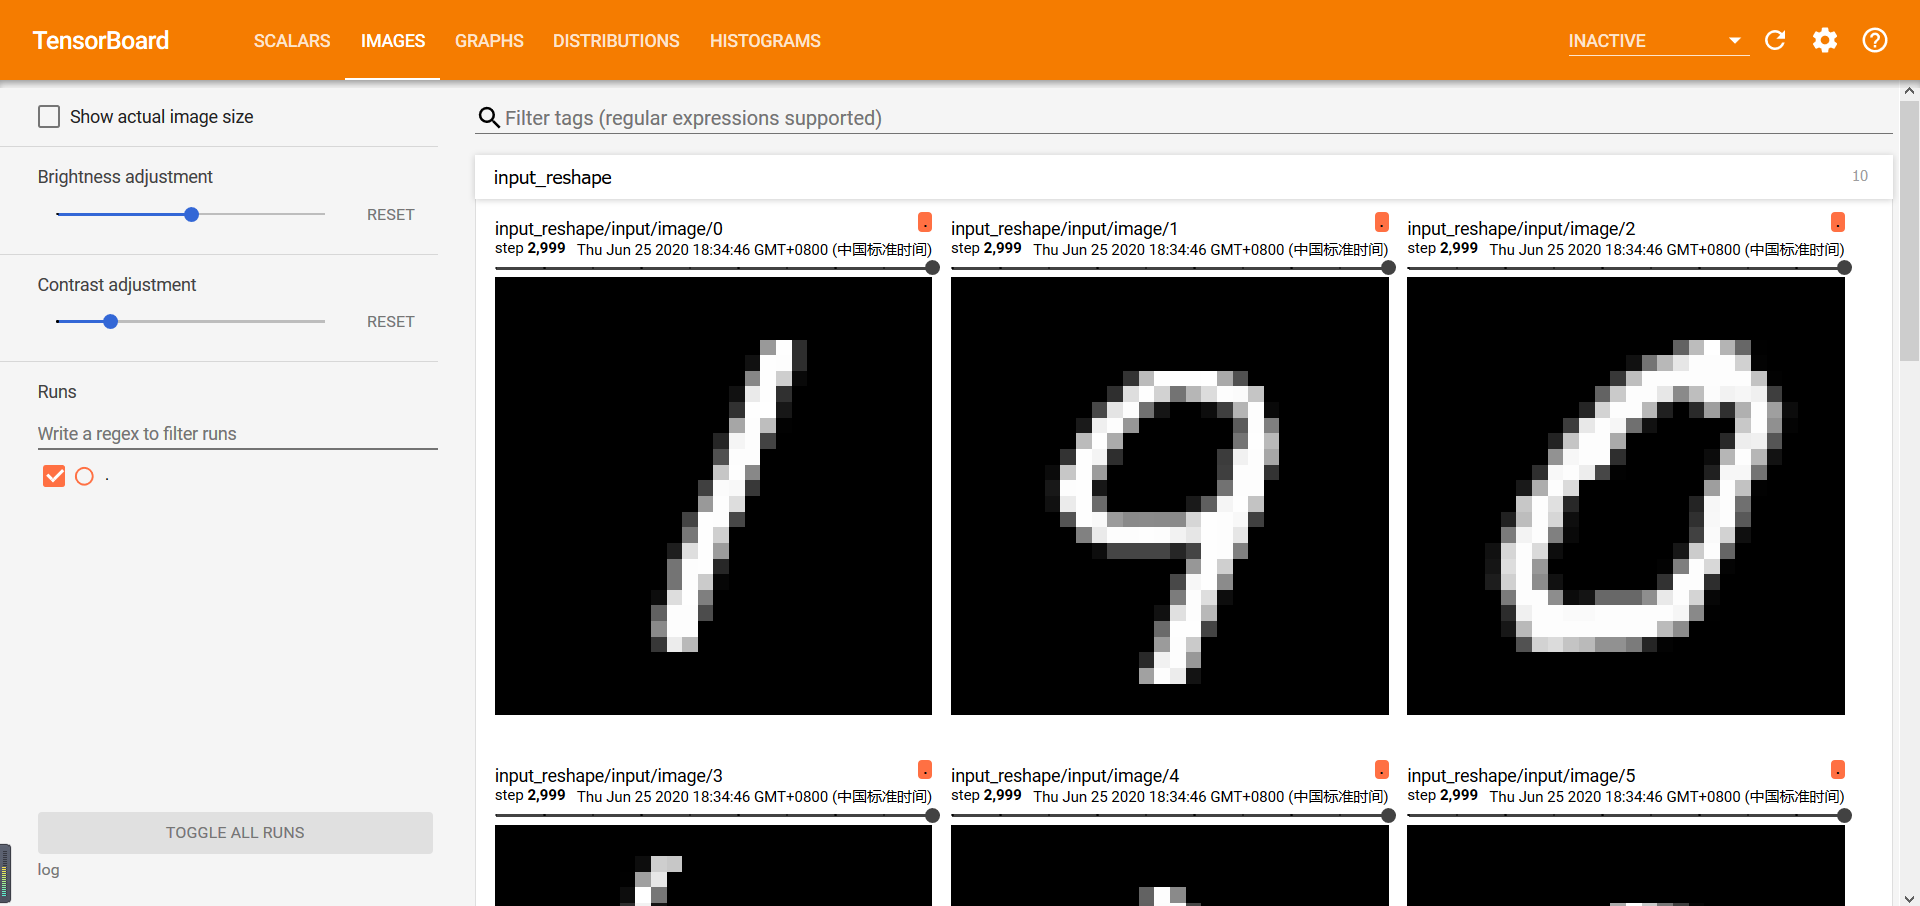

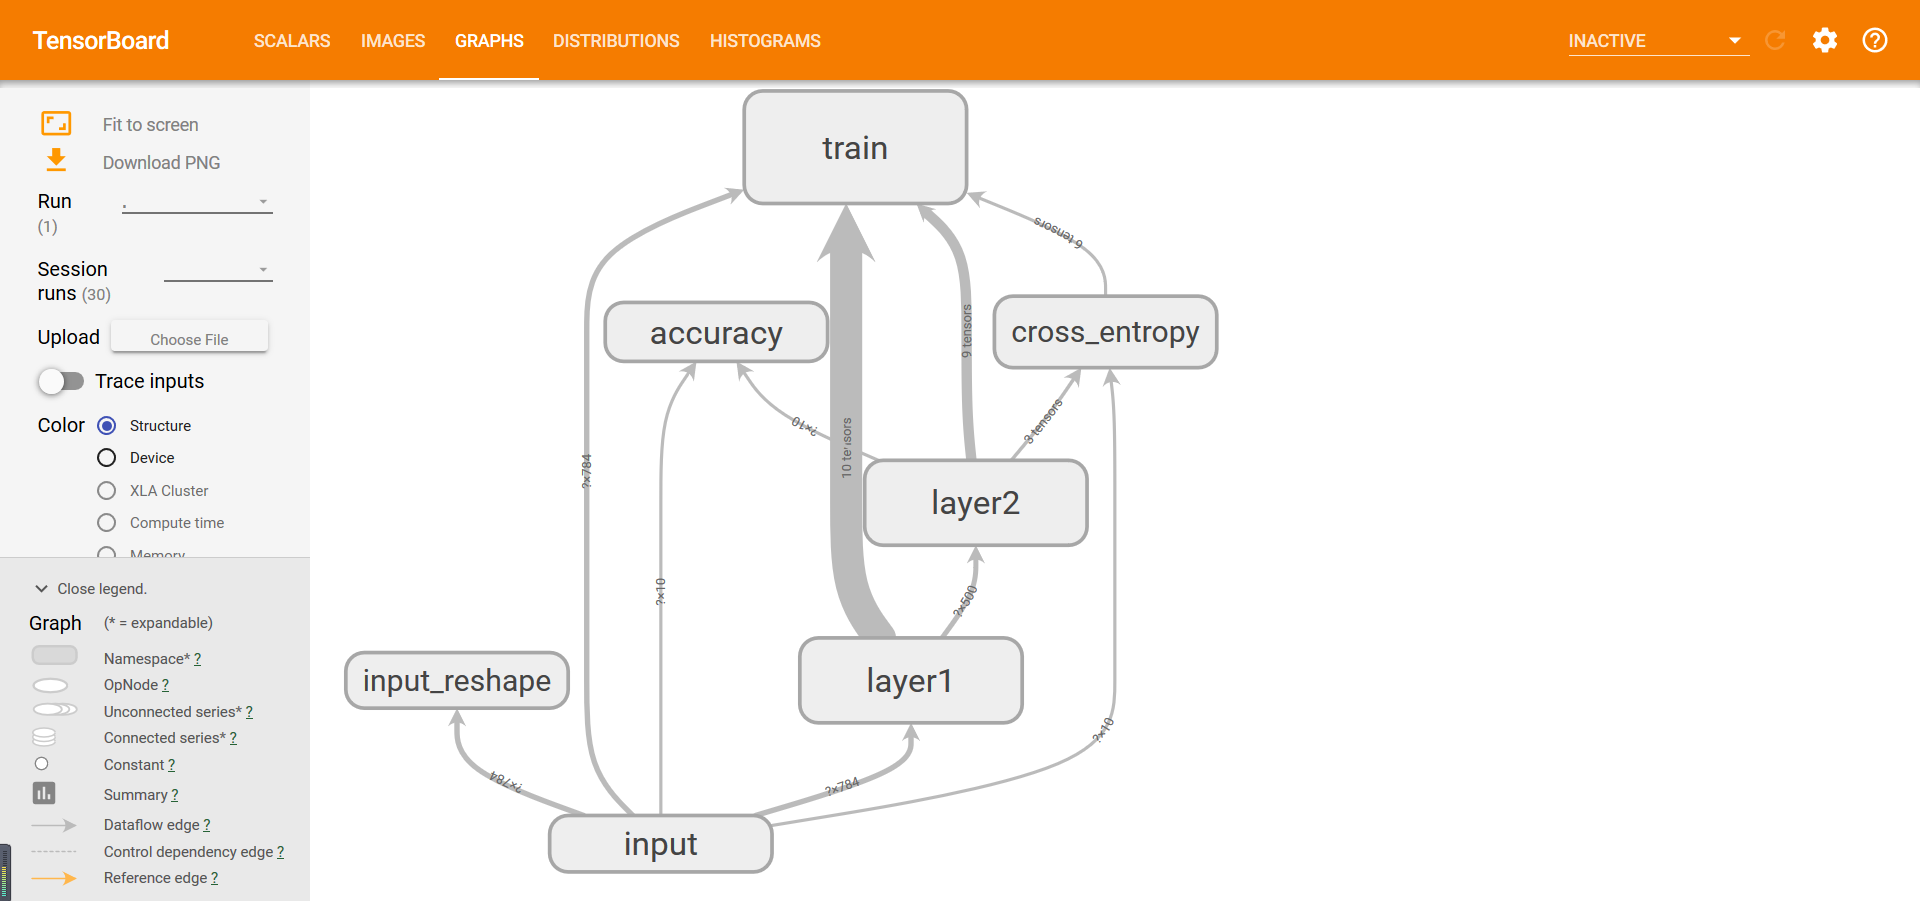

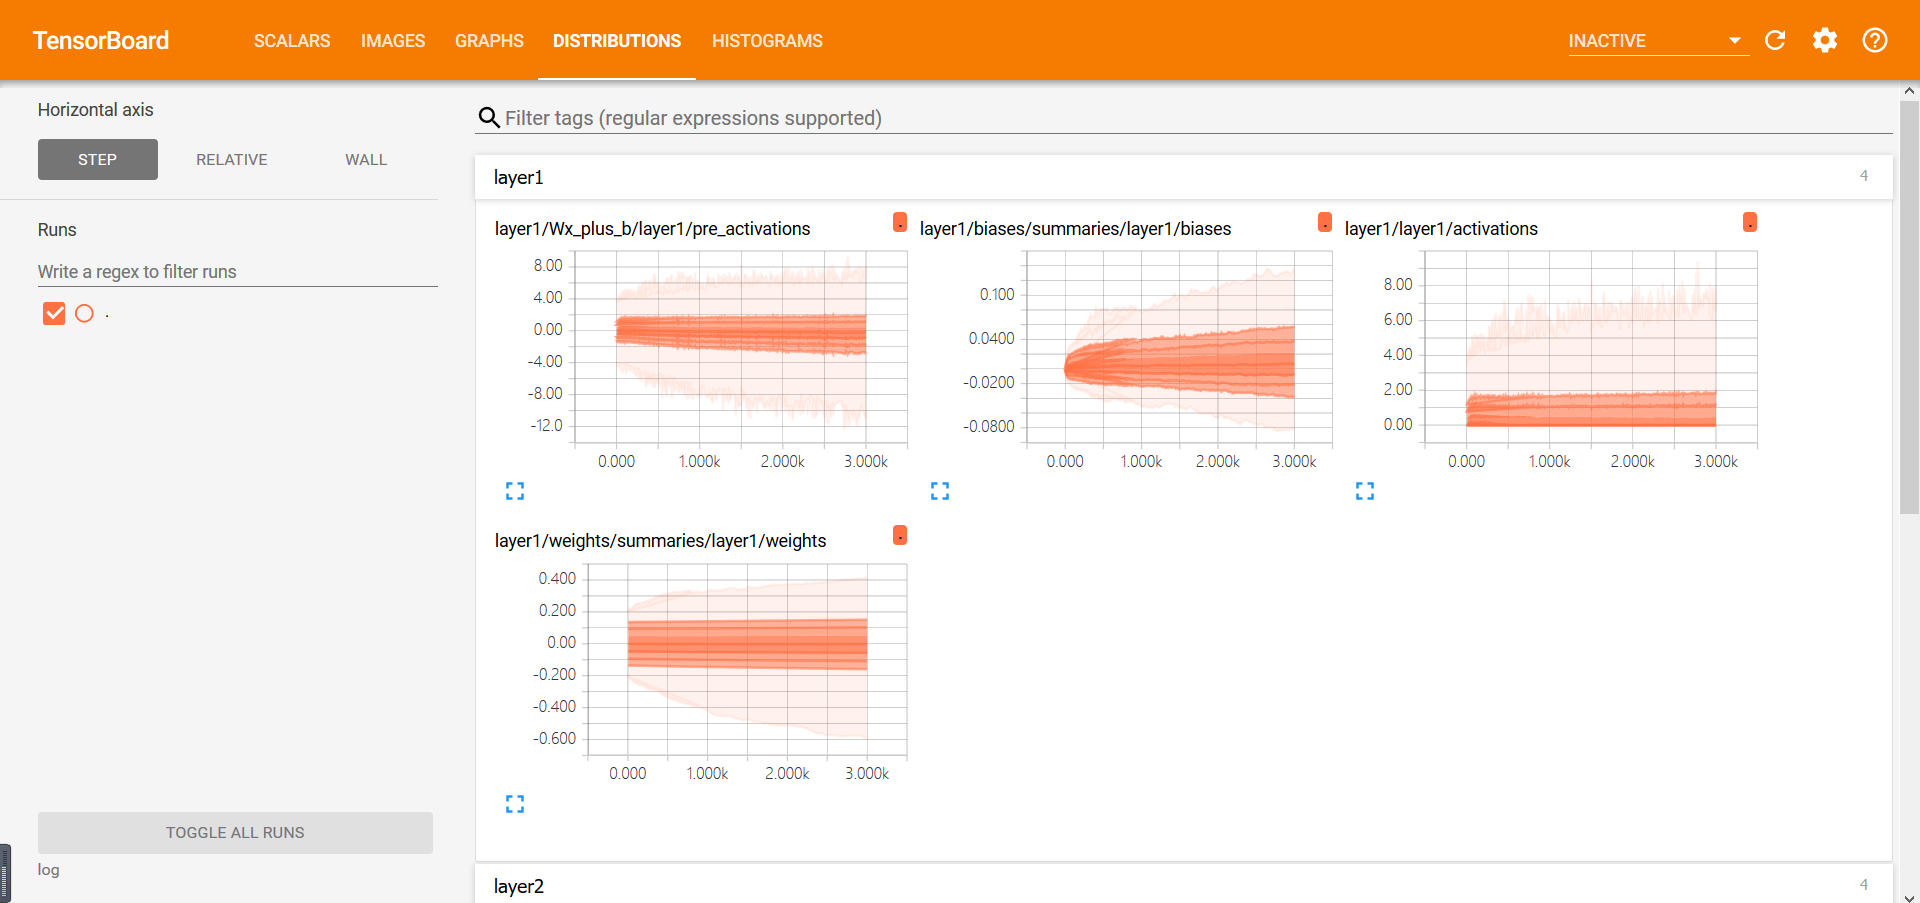

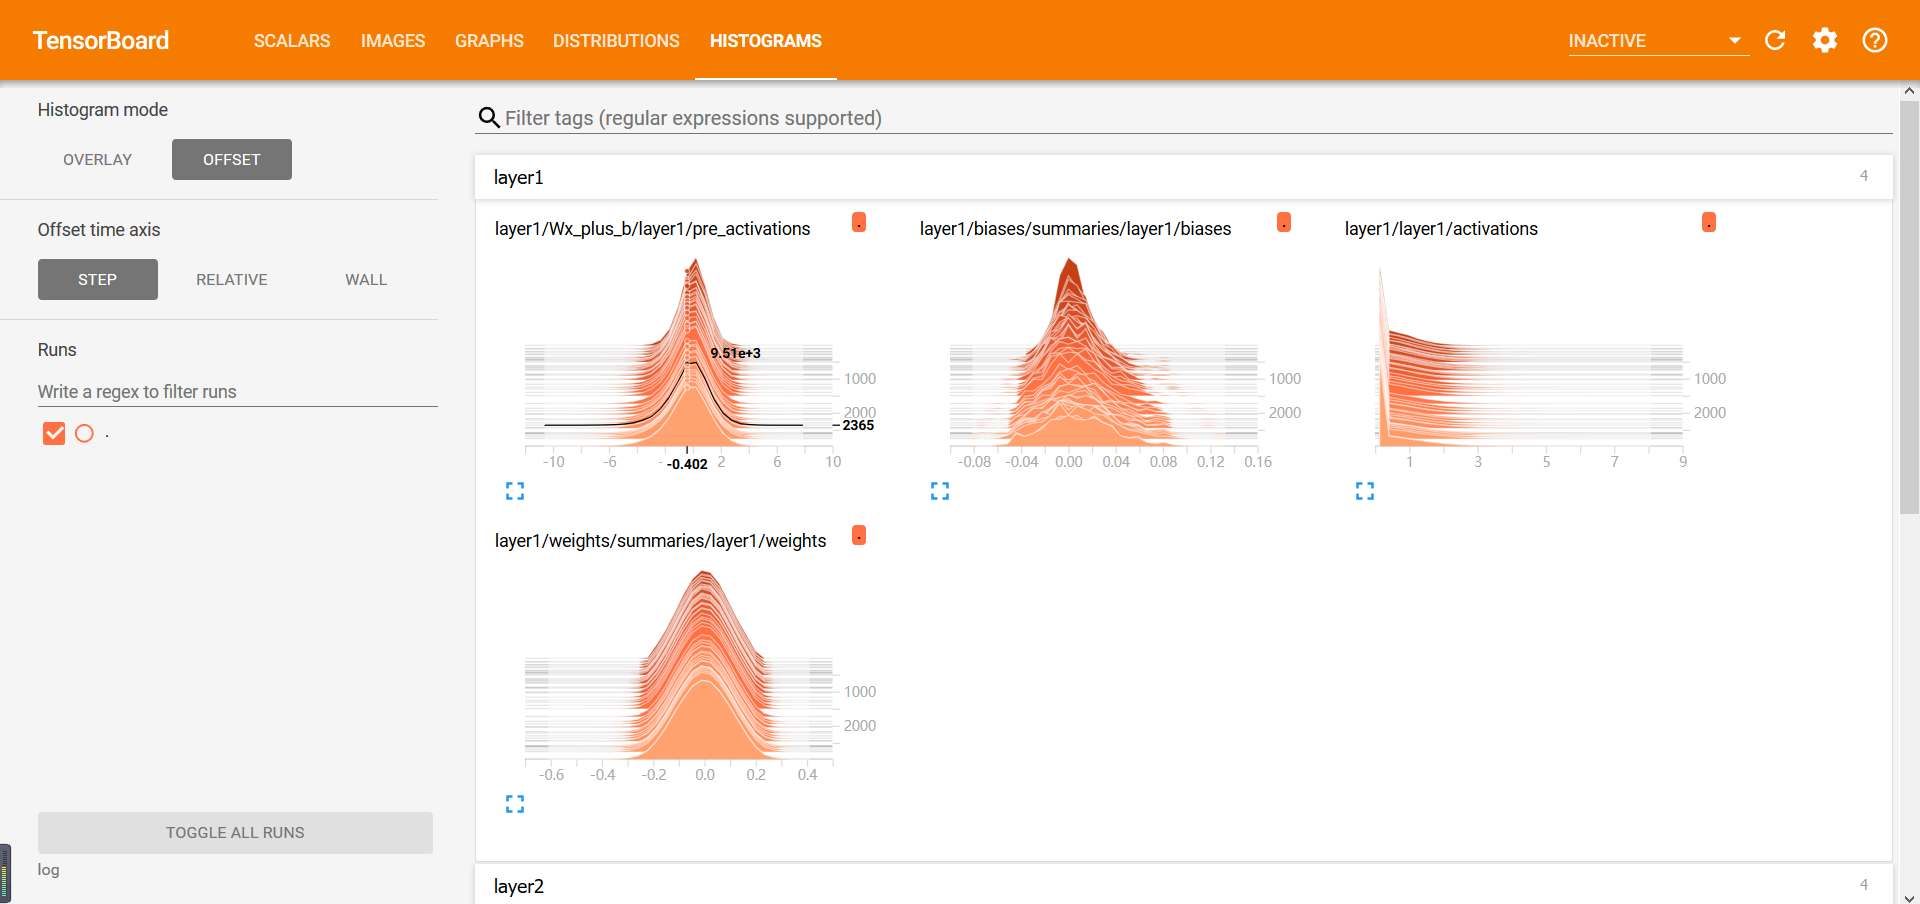

## 高维变量可视化

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz


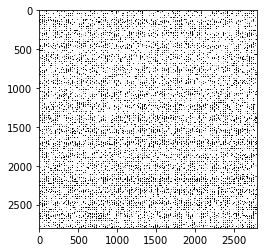

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.examples.tutorials.mnist import input_data

# PROJECTOR需要的日志文件名和地址相关参数
LOG_DIR = '/opt/jupyter_files/log'
SPRITE_FILE = 'mnist_sprite.jpg'
META_FIEL = "mnist_meta.tsv"

# 使用给出的MNIST图片列表生成sprite图像
def create_sprite_image(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    # sprite图像可以理解为所有小图片拼成的大正方形矩阵
    # 大正方形矩阵中的每一个元素就是原来的小图片
    # 于是这正方形的边长就是sprt(n)，其中n为小图片的数量
    m = int(np.ceil(np.sqrt(images.shape[0])))
    
    # 使用全1来初始化最终的大图片
    sprite_image = np.ones((img_h * m ,img_w * m ))
    
    for i in range(m):
        for j in range(m):
            # 计算当前图片的编号
            cur = i * m + j
            if cur < images.shape[0]:
                sprite_image[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = images[cur]
    
    return sprite_image
    
# 加载MNIST数据。这里one_hot=False，于是labels就是一个数字，表示图片所表示的数字
mnist = input_data.read_data_sets("/opt/jupyter_files/MNIST", False, one_hot=False)

# 生成sprite图像
to_visualise = 1 - np.reshape(mnist.test.images, (-1, 28, 28))
sprite_image = create_sprite_image(to_visualise)

# 将生成的sprite图像放到相应的日志目录下
path_for_mnist_sprites = os.path.join(LOG_DIR, SPRITE_FILE)
plt.imsave(path_for_mnist_sprites, sprite_image, cmap='gray')
plt.imshow(sprite_image, cmap='gray')

# 生成每张图片对应的标签文件并写到相应的日志目录下
path_for_mnist_metadata = os.path.join(LOG_DIR, META_FIEL)

with open(path_for_mnist_metadata, 'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%d\n" % (index, label))

In [37]:
import tensorflow as tf

INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500

def get_weight_variable(shape, regularizer):
    weights = tf.get_variable("weights",
                              shape,
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    if regularizer != None:
        tf.add_to_collection('losses', regularizer(weights))
    return weights


def inference(input_tensor, regularizer):
    with tf.variable_scope('layer1'):
        weights = get_weight_variable([INPUT_NODE, LAYER1_NODE], regularizer)
        biases = tf.get_variable("biases",
                                 [LAYER1_NODE],
                                 initializer=tf.constant_initializer(0.0))
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + biases)

    with tf.variable_scope('layer2'):
        weights = get_weight_variable([LAYER1_NODE, OUTPUT_NODE], regularizer)
        biases = tf.get_variable("biases",
                                 [OUTPUT_NODE],
                                 initializer=tf.constant_initializer(0.0))
        layer2 = tf.matmul(layer1, weights) + biases

    return layer2

In [38]:
import tensorflow as tf
import os

# 加载用于生成PROJECTOR日志的帮助函数
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 10000
MOVING_AVERAGE_DECAY = 0.99

LOG_DIR = '/opt/jupyter_files/log'
SPRITE_FILE = 'mnist_sprite.jpg'
META_FIEL = "mnist_meta.tsv"
TENSOR_NAME = "FINAL_LOGITS"

# 与第5章不同的是这里还需要返回最后测试数据经过整个神经网络得到的输出层矩阵
# 因为有多张测试图片，每张图片对应了一个输出层向量
# 所以返回的结果是这些向量组成的矩阵
def train(mnist):
    #  输入数据的命名空间。
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    y = inference(x, regularizer)
    global_step = tf.Variable(0, trainable=False)
    
    # 处理滑动平均的命名空间。
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY,
                                                              global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
   
    # 计算损失函数的命名空间。
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                       labels=tf.argmax(y_, 1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    
    # 定义学习率、优化方法及每一轮执行训练的操作的命名空间。
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE,
            global_step,
            mnist.train.num_examples / BATCH_SIZE,
            LEARNING_RATE_DECAY,
            staircase=True)

        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,
                                                                               global_step=global_step)

        with tf.control_dependencies([train_step, variables_averages_op]):
            train_op = tf.no_op(name='train')
    
    # 训练模型。
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, step = sess.run([train_op, loss, global_step],
                                           feed_dict={x: xs, y_: ys})
                
            if i % 1000 == 0:
                print("After %d training step(s), loss on training batch is %g." % 
                      (i, loss_value))
        
        # 计算MNIST测试数据对应的输出层矩阵
        final_result = sess.run(y, feed_dict={x: mnist.test.images})
    # 返回输出层矩阵的值
    return final_result

# 生成可视化最终输出层向量所需要的日志文件
def visualisation(final_result):
    # 使用一个新的变量来保存最终输出层向量的结果
    # 因为embedding是通过Tensorflow中变量完成的
    # 所以PROJECTOR可视化的都是Tensorflow中的变量
    # 于是这里需要新定义一个变量来保持输出层向量的取值
    y = tf.Variable(final_result, name = TENSOR_NAME)
    summary_writer = tf.summary.FileWriter(LOG_DIR)

    # 通过projector.ProjectorConfig类来帮助生成日志文件
    config = projector.ProjectorConfig()
    # 增加一个需要可视化的embedding结果
    embedding = config.embeddings.add()
    # 指定这个embedding结果对应的Tensorflow变量名称
    embedding.tensor_name = y.name

    # 指定embedding结果所对应的原始数据信息
    # 比如这里指定的就是每一张MNIST测试图片对应的真实类别
    # 在单词向量中可以是单词ID对应的单词
    # 这个文件是可选的，如果没有指定那么向量就没有标签
    embedding.metadata_path = META_FIEL

    # 指定sprite图像。这个也是可选的
    # 如果没有提供sprite图像，那么可视化的结果每一个点就是一个小圆点，而不是具体图片
    embedding.sprite.image_path = SPRITE_FILE
    # 在提供sprite图像时，通过single_image_dim可以指定单张图片的大小
    # 这将用于从sprite图像中截取正确的原始图片
    embedding.sprite.single_image_dim.extend([28, 28])

    # 将PROJECTOR所需要的内容写入日志文件
    projector.visualize_embeddings(summary_writer, config)
    
    # 生成会话，初始化新声明的变量并将需要的日志信息写入文件
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR, "model"), TRAINING_STEPS)
    
    summary_writer.close()
    
# 主函数先调用模型训练的过程，再使用训练好的模型来处理MNIST测试数据
# 最后将得到的输入层矩阵输出到PROJECTOR需要的日志文件中
def main(argv=None): 
    mnist = input_data.read_data_sets("/opt/jupyter_files/MNIST", False, one_hot=True)
    final_result = train(mnist)
    visualisation(final_result)

if __name__ == '__main__':
    main()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
After 0 training step(s), loss on training batch is 2.89897.
After 1000 training step(s), loss on training batch is 0.299121.
After 2000 training step(s), loss on training batch is 0.139065.
After 3000 training step(s), loss on training batch is 0.164265.
After 4000 training step(s), loss on training batch is 0.114324.
After 5000 training step(s), loss on training batch is 0.11553.
After 6000 training step(s), loss on training batch is 0.143035.
After 7000 training step(s), loss on training batch is 0.0887057.
After 8000 training step(s), loss on training batch is 0.0832981.
After 9000 training step(s), loss on training batch is 0.071562.


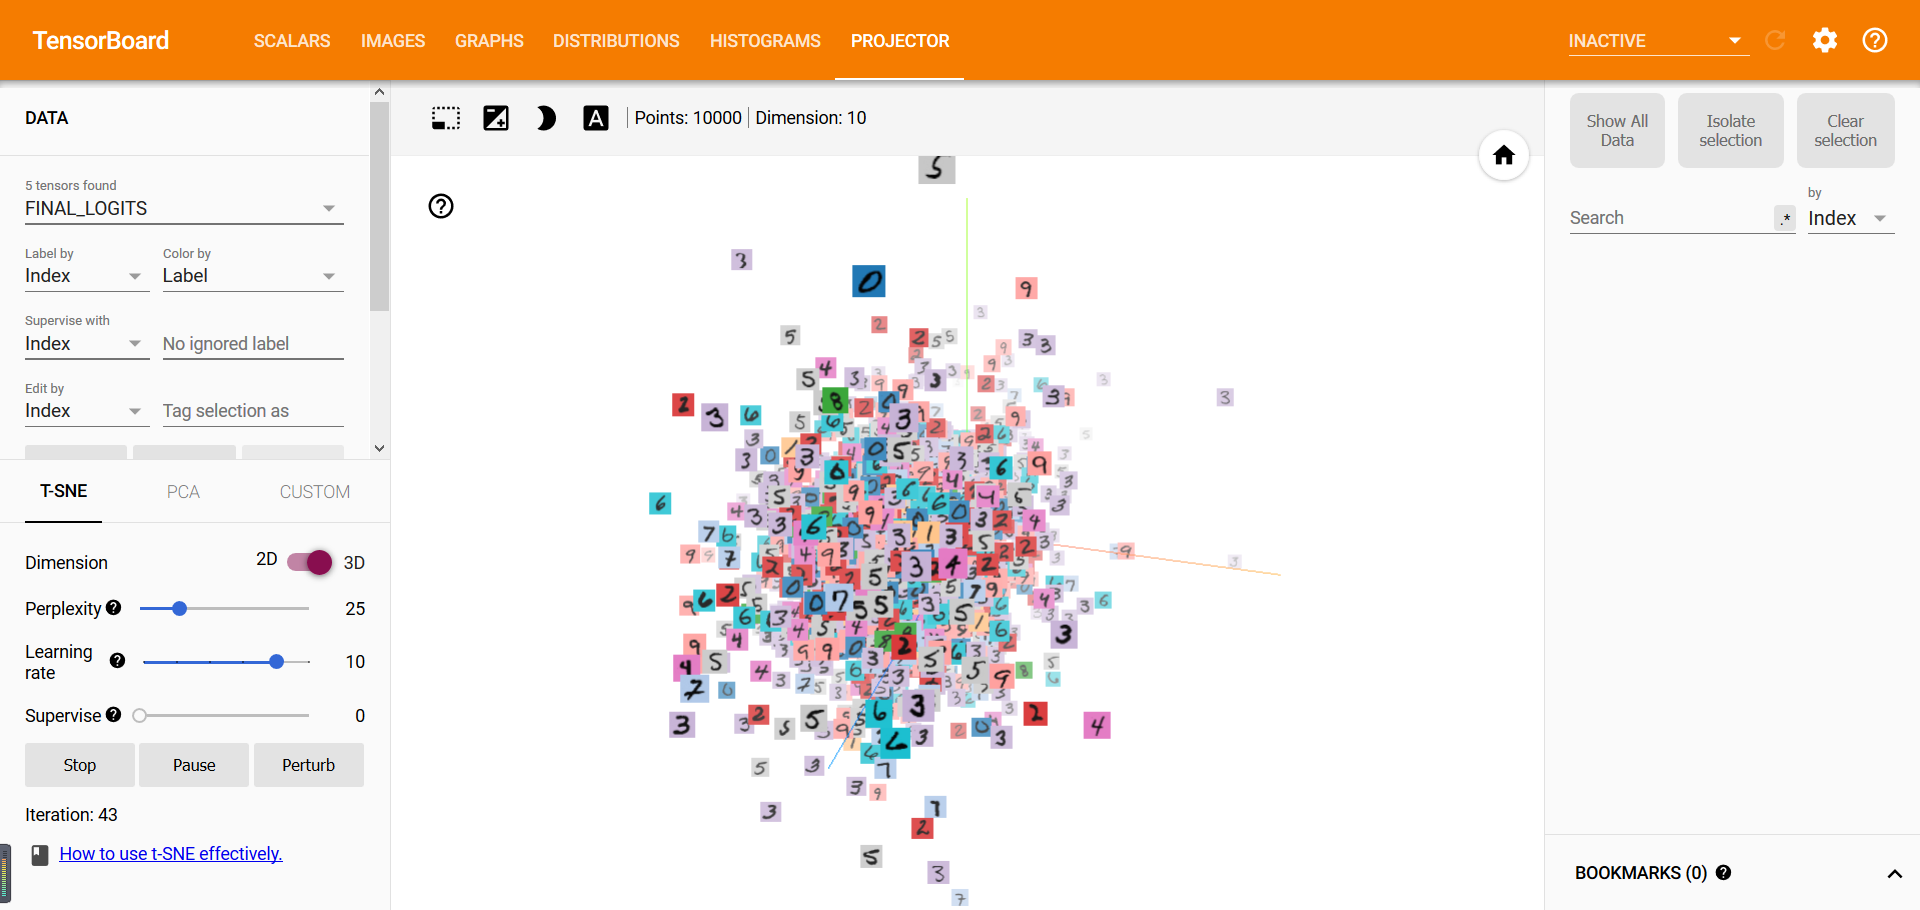

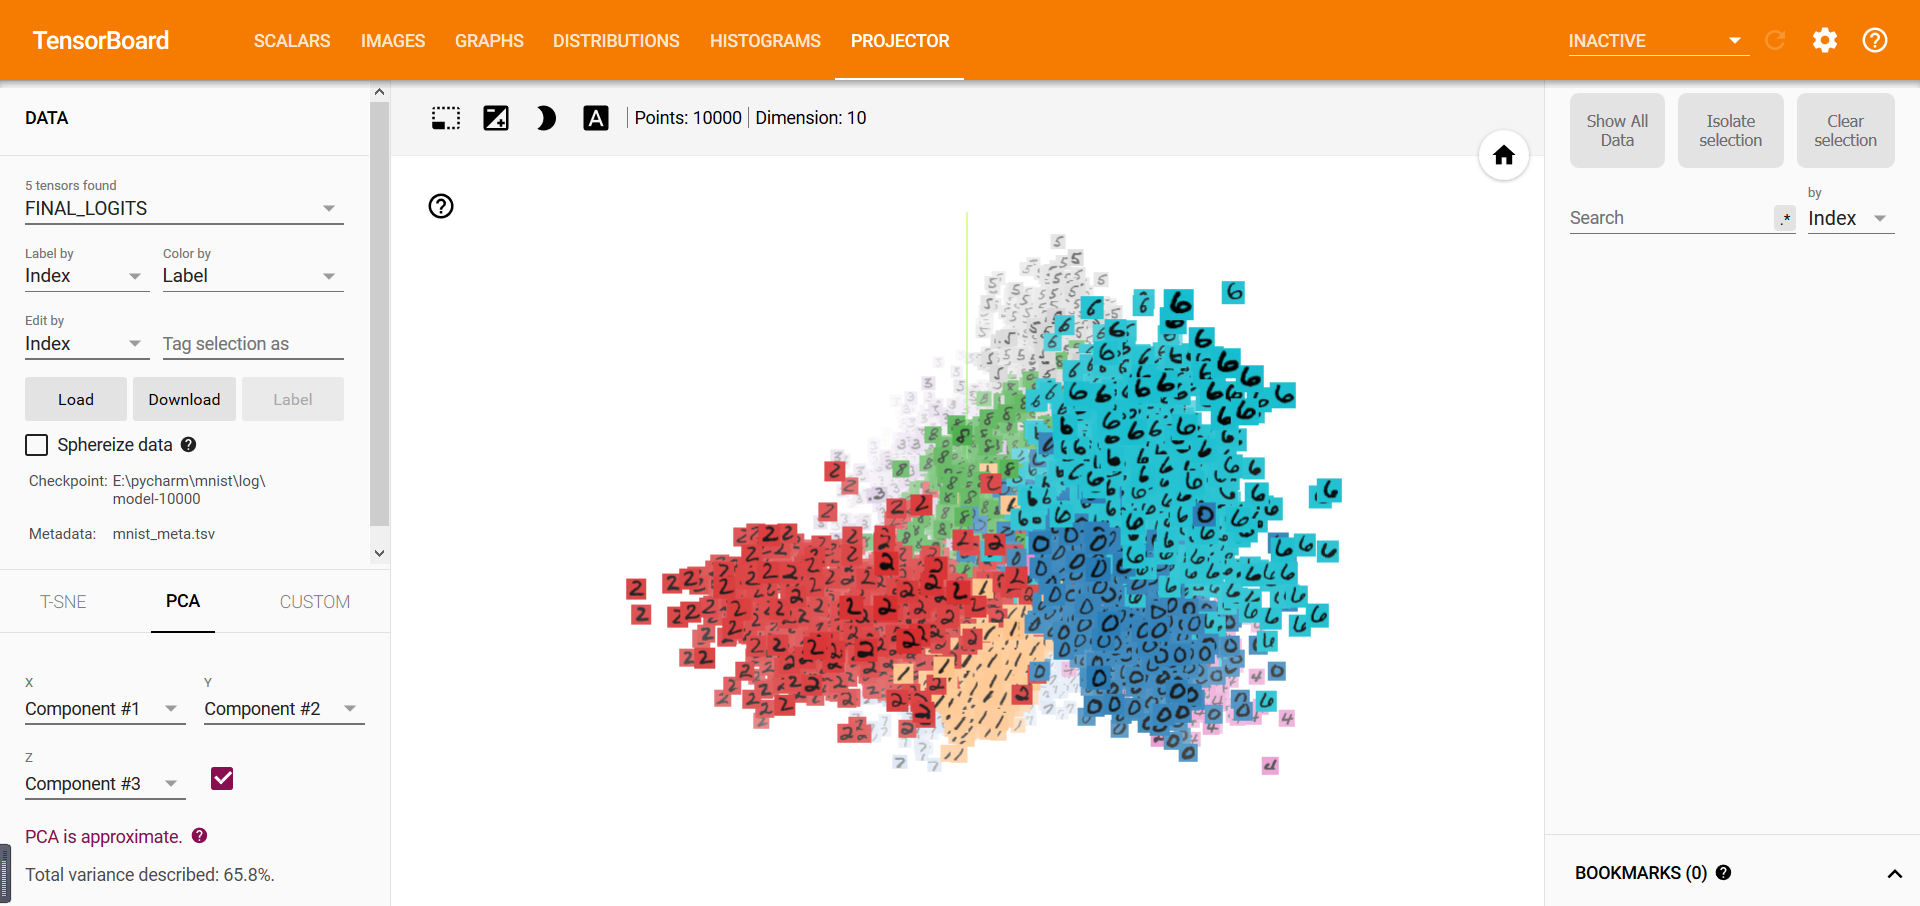